# Homework 06

SOLVED by ANGELA CARRARO

## Exercise 1

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

1. Download and import Load the smoking dataset from: [https://data.princeton.edu/wws509/datasets/#smoking](https://data.princeton.edu/wws509/datasets/#smoking). Then perform a train-test split on the data;
2. Fit a Poisson bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables;
3. Evaluate the regression fit on test data using MAE and MSE error metrics.

**Solution.**



In [1]:
import os
import math
import pandas as pd
import numpy as np
from sklearn import gaussian_process
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
import matplotlib as mt
import seaborn as sns

import pyro
import torch
import pyro.distributions as dist
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import Predictive
import torch.distributions.constraints as constraints

sns.set_style("darkgrid")
figsize=(10,4)
pyro.set_rng_seed(0)

#### Smoking and Lung Cancer

This dataset has information from a Canadian study of mortality by age and smoking status.

The file in "raw" format, `smoking.raw`, has four columns:

- age at the start of follow-up: in five-year age groups coded 1 to 9 for 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74, 75-79, 80+.
- smoking status: coded 1 = never smoked, 2 = smoked cigars or pipe only, 3 = smoked cigarettes and cigar or pipe, and 4 = smoked cigarettes only,
- population: number of male pensioners followed, and
- deaths: number of deaths in a six-year period.

In [2]:
# Load the dataset
data_smoking = pd.read_table(os.path.join("data", "smoking.raw"),  header=None)
data_smoking.head()

,0,1,2,3
0,1,1,656,18
1,2,1,359,22
2,3,1,249,19
3,4,1,632,55
4,5,1,1067,117


In [3]:
data_smoking.columns = ["age", "smoke", "pop", "dead"]
data_smoking.head(10)

,age,smoke,pop,dead
0,1,1,656,18
1,2,1,359,22
2,3,1,249,19
3,4,1,632,55
4,5,1,1067,117
5,6,1,897,170
6,7,1,668,179
7,8,1,361,120
8,9,1,274,120
9,1,2,145,2


In [4]:
data_smoking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     36 non-null     int64
 1   smoke   36 non-null     int64
 2   pop     36 non-null     int64
 3   dead    36 non-null     int64
dtypes: int64(4)
memory usage: 1.2 KB


In [5]:
# dataset columns to torch tensors
deaths = torch.tensor(data_smoking["dead"].values, dtype=torch.float)
predictors = torch.stack([torch.tensor(data_smoking[column].values, dtype=torch.float)
                           for column in ["age","smoke","pop"]], 1)
predictors[:5]

tensor([[1.0000e+00, 1.0000e+00, 6.5600e+02],
        [2.0000e+00, 1.0000e+00, 3.5900e+02],
        [3.0000e+00, 1.0000e+00, 2.4900e+02],
        [4.0000e+00, 1.0000e+00, 6.3200e+02],
        [5.0000e+00, 1.0000e+00, 1.0670e+03]])

In [6]:
# dataset normalization
predictors = (predictors - predictors.min())/(predictors.max() - predictors.min())
predictors[:5]

tensor([[0.0000e+00, 0.0000e+00, 1.0825e-01],
        [1.6526e-04, 0.0000e+00, 5.9164e-02],
        [3.3052e-04, 0.0000e+00, 4.0985e-02],
        [4.9579e-04, 0.0000e+00, 1.0428e-01],
        [6.6105e-04, 0.0000e+00, 1.7617e-01]])

Now we perform a train-test split on the data:
- **train data** - 80% of the observations will be used to perfom inference on our model
- **test data** - the remaining 20% will be used for testing the correctness of posterior predictions 

In [7]:
import random as rd

rd.seed(0)

k = int(0.8 * len(data_smoking))
kk = rd.sample(range(len(predictors)), k)
xx = list(range(len(predictors)))
for i in range(k):
    xx.remove(kk[i])

x_train, y_train = predictors[kk], deaths[kk]
x_test, y_test = predictors[xx], deaths[xx]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([28, 3]) 
y_train.shape = torch.Size([28])

x_test.shape = torch.Size([8, 3]) 
y_test.shape = torch.Size([8])


Now we fit a Poisson Bayesian regression model using the number of deaths as the response variable and the other columns as the explanatory variables.

Poisson regression is a Generalized Linear Model, used to model count data. It takes the form

$$\mathbb{E}(\mu|x)=\exp(w_1\,x_1+\ldots+w_k\,x_k+b),$$

where the observed counts $y$ are drawn from a Poisson distribution on the expected counts: 

$$y_i \sim \text{Poisson}(\mu_i).$$

We set a normal prior on $w$, a Log-Normal on the bias term $b$

\begin{align*}
w&\sim\mathcal{N}(0,1)\\
b&\sim\text{LogNormal}(0,1)\\
\mu&= \exp(w x + b)\\
y &\sim \text{Poisson}(\mu).
\end{align*}

In [8]:
# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

In [9]:
# modelling rain in terms of the predictors
def smoking_model(predictors, deaths):

    n_observations, n_predictors = predictors.shape
    
    # sample weights
    w = pyro.sample("w", dist.Normal(20 * torch.rand(n_predictors), 5 * torch.ones(n_predictors)))
    # w = pyro.sample("w", dist.Gamma(70 * torch.ones(n_predictors), 20 * torch.ones(n_predictors)))
    b = pyro.sample("b", dist.LogNormal(torch.zeros(1), torch.ones(1)))
    
    mu = torch.exp(((w*predictors).sum(dim=1) + b))
    
    # condition on the observations
    with pyro.plate("deaths", len(deaths)):
        pyro.sample("obs", dist.Poisson(mu), obs=deaths)
        
def smoking_guide(predictors, deaths=None):
    
    n_observations, n_predictors = predictors.shape
        
    # w_loc = pyro.param("w_loc", torch.rand(n_predictors), constraint=constraints.positive)
    w_loc = pyro.param("w_loc", torch.rand(n_predictors))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors), constraint=constraints.positive)

    #w = pyro.sample("w", dist.Gamma(70 * w_loc, 20* w_scale))
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1))
    b_scale = pyro.param("b_scale", torch.rand(1), constraint=constraints.positive)
    
    b = pyro.sample("b", dist.LogNormal(b_loc, b_scale))
    
    
smoking_svi = SVI(model=smoking_model, guide=smoking_guide, 
              optim=optim.ClippedAdam({'lr' : 0.0005}), 
              loss=Trace_ELBO()) 

In [10]:
losses = []
for step in range(10001):
    loss = smoking_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 2000 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 823.1546600120408
Step 2000 : loss = 360.4965447826045
Step 4000 : loss = 127.26087361574173
Step 6000 : loss = 88.09165933302471
Step 8000 : loss = 73.12630366853305
Step 10000 : loss = 70.39570542318481


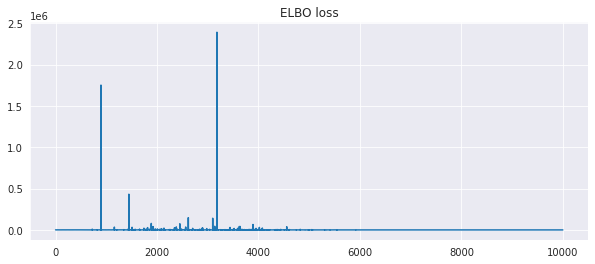

In [11]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

We can extract the inferred parameters as follows.

In [12]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 2.82778955
w_1 = 2.32619619
w_2 = 2.21726561
b = 1.56204975


**Posterior predictive distribution**

We can use the `Predictive` utility class, corresponding to the posterior predictive distribution, to evaluate our model on test data. Here we compute some summary statistics (mean, std and quantiles) on $100$ samples from the posterior predictive:

In [13]:
# print latent params quantile information
def summary(samples):
    stats = {}
    for par_name, values in samples.items():
        marginal = pd.DataFrame(values)
        percentiles=[.05, 0.5, 0.95]
        describe = marginal.describe(percentiles).transpose()
        stats[par_name] = describe[["mean", "std", "5%", "50%", "95%"]]
    return stats

# define the posterior predictive
predictive = Predictive(model=smoking_model, guide=smoking_guide, num_samples=100, return_sites=("w","b"))

# get posterior samples on test data
svi_samples = {k: v.detach().numpy() for k, v in predictive(x_test, y_test).items()}

# show summary statistics
for key, value in summary(svi_samples).items():
    print(f"Sampled parameter = {key}\n\n{value}\n")

Sampled parameter = w

       mean       std        5%       50%       95%
0  2.851047  1.346063  1.052813  2.767219  5.252923
1  2.692300  2.818954 -1.825420  2.503240  7.616545
2  2.242400  0.251535  1.843345  2.246257  2.607991

Sampled parameter = b

       mean       std        5%       50%       95%
0  4.775244  0.120554  4.584116  4.783401  4.961614



Now we evaluate the regression fit on test data using MAE and MSE error metrics.

In [14]:
# compute predictions using the inferred paramters
# we use the mean of the distribution as predictor
y_pred = torch.exp((inferred_w * x_test).sum(1) + inferred_b)

print("Predicted labels: ", y_pred)
print("True labels: ", y_test)

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())

Predicted labels:  tensor([ 6.0621,  6.7676,  5.8274, 14.4863, 26.5619, 43.9017, 15.8388,  7.4151],
       grad_fn=<ExpBackward>)
True labels:  tensor([  18.,  173.,  253.,  169.,  576., 1001.,  514.,  432.])
MAE = 376.14239501953125
MSE = 219887.59375


### Another model

We can see that the prediction is not much accurate. Let's try to manipulate the model, adding the interaction terms among the predicotrs.

In [15]:
# dataset columns to torch tensors
deaths = torch.tensor(data_smoking["dead"].values, dtype=torch.float)
predictors = torch.stack([torch.tensor(data_smoking[column].values, dtype=torch.float)
                           for column in ["age","smoke","pop"]], 1)
predictors = torch.stack([predictors[:,0], predictors[:,1], predictors[:,2],
                                      predictors[:,0]*predictors[:,1],
                                      predictors[:,0]*predictors[:,2],
                                      predictors[:,1]*predictors[:,2],
                                      predictors[:,0]*predictors[:,1]*predictors[:,2]],1)
predictors[:5, :]

tensor([[1.0000e+00, 1.0000e+00, 6.5600e+02, 1.0000e+00, 6.5600e+02, 6.5600e+02,
         6.5600e+02],
        [2.0000e+00, 1.0000e+00, 3.5900e+02, 2.0000e+00, 7.1800e+02, 3.5900e+02,
         7.1800e+02],
        [3.0000e+00, 1.0000e+00, 2.4900e+02, 3.0000e+00, 7.4700e+02, 2.4900e+02,
         7.4700e+02],
        [4.0000e+00, 1.0000e+00, 6.3200e+02, 4.0000e+00, 2.5280e+03, 6.3200e+02,
         2.5280e+03],
        [5.0000e+00, 1.0000e+00, 1.0670e+03, 5.0000e+00, 5.3350e+03, 1.0670e+03,
         5.3350e+03]])

In [16]:
# dataset normalization
predictors = (predictors - predictors.min())/(predictors.max() - predictors.min())
predictors[:5]

tensor([[0.0000e+00, 0.0000e+00, 7.2153e-03, 0.0000e+00, 7.2153e-03, 7.2153e-03,
         7.2153e-03],
        [1.1016e-05, 0.0000e+00, 3.9436e-03, 1.1016e-05, 7.8983e-03, 3.9436e-03,
         7.8983e-03],
        [2.2032e-05, 0.0000e+00, 2.7319e-03, 2.2032e-05, 8.2178e-03, 2.7319e-03,
         8.2178e-03],
        [3.3047e-05, 0.0000e+00, 6.9509e-03, 3.3047e-05, 2.7837e-02, 6.9509e-03,
         2.7837e-02],
        [4.4063e-05, 0.0000e+00, 1.1743e-02, 4.4063e-05, 5.8758e-02, 1.1743e-02,
         5.8758e-02]])

In [17]:
x_train, y_train = predictors[kk], deaths[kk]
x_test, y_test = predictors[xx], deaths[xx]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([28, 7]) 
y_train.shape = torch.Size([28])

x_test.shape = torch.Size([8, 7]) 
y_test.shape = torch.Size([8])


In [18]:
# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

In [19]:
losses = []
for step in range(10001):
    loss = smoking_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 2000 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 637.5884595800724
Step 2000 : loss = 237.31431161505836
Step 4000 : loss = 63.50911176630429
Step 6000 : loss = 39.4544186762401
Step 8000 : loss = 33.7751430954252
Step 10000 : loss = 28.554901983056748


In [20]:
print("Inferred params:", list(pyro.get_param_store().keys()), end="\n\n")

# w_i and b posterior mean
inferred_w = pyro.get_param_store()["w_loc"]
inferred_b = pyro.get_param_store()["b_loc"]

for i,w in enumerate(inferred_w):
    print(f"w_{i} = {w.item():.8f}")
print(f"b = {inferred_b.item():.8f}")

Inferred params: ['w_loc', 'w_scale', 'b_loc', 'b_scale']

w_0 = 3.34316874
w_1 = 3.45300436
w_2 = 0.94054240
w_3 = 3.00234008
w_4 = 2.56268573
w_5 = 1.75803959
w_6 = 1.85872817
b = 1.50376582


In [21]:
# compute predictions using the inferred paramters
# we use the mean of the distribution as predictor
y_pred = torch.exp((inferred_w * x_test).sum(1) + inferred_b)

print("Predicted labels: ", y_pred)
print("True labels: ", y_test)

print("MAE =", torch.nn.L1Loss()(y_test, y_pred).item())
print("MSE =", torch.nn.MSELoss()(y_test, y_pred).item())

Predicted labels:  tensor([  4.7357,   6.9921,   6.4578,   9.5325,  33.2428, 102.6860,  25.3331,
         12.5675], grad_fn=<ExpBackward>)
True labels:  tensor([  18.,  173.,  253.,  169.,  576., 1001.,  514.,  432.])
MAE = 366.80657958984375
MSE = 203777.484375


Not even adding predictors improves the learning.

The most likely problem is that we have too few data to learn the model.

## Exercise 2

The Iris dataset contains petal and sepal length and width for three different types of Iris flowers: Setosa, Versicolour, and Virginica.

1. Import the Iris dataset from `sklearn`:
```
from sklearn import datasets
iris = datasets.load_iris()
```
and perform a train-test split on the data.

2. Fit a multinomial bayesian logistic regression model on the four predictors petal length/width and sepal length/width. 

3. Evaluate your bayesian classifier on test data: compute the overall test accuracy and class-wise accuracy for the three different flower categories.

**Solution.**

In [22]:
from sklearn import datasets
iris = datasets.load_iris()
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names']).assign(
                                                    Species=iris['target_names'][iris['target']])
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [23]:
# select predictors
df = iris_df[iris['feature_names']]
# dataset normalization
df = (df-df.min())/(df.max()-df.min())
df.head()

# dataset columns to torch tensor of features/predictors
predictors = torch.stack([torch.tensor(df[column].values, dtype=torch.float) for column in df], dim=1)

# classification labels
labels = torch.tensor(iris["target"], dtype=torch.float)
# one hot enconding of the species
# labels = torch.eye(n_class)[iris["target"]]

# number of different classes
n_class = 3

Now we perform a train-test split on the data:
- **train data** - 80% of the observations will be used to perfom inference on our model
- **test data** - the remaining 20% will be used for testing the correctness of posterior predictions

Since the data are ordered by species, we have to randomly pick the training set.

In [24]:
k = int(0.8 * len(labels))
kk = rd.sample(range(len(labels)), k)
xx = list(range(len(labels)))
for i in range(k):
    xx.remove(kk[i])

x_train, y_train = predictors[kk], labels[kk]
x_test, y_test = predictors[xx], labels[xx]

print("x_train.shape =", x_train.shape,"\ny_train.shape =", y_train.shape)
print("\nx_test.shape =", x_test.shape,"\ny_test.shape =", y_test.shape)

x_train.shape = torch.Size([120, 4]) 
y_train.shape = torch.Size([120])

x_test.shape = torch.Size([30, 4]) 
y_test.shape = torch.Size([30])


In [25]:
# delete previously inferred params from pyro.param_store()
pyro.clear_param_store()

def log_reg_model(x, y):
    n_observations, n_predictors = x.shape
    
    w = pyro.sample("w", dist.Normal(torch.zeros(n_predictors, n_class), torch.ones(n_predictors, n_class)))
    b = pyro.sample("b", dist.Normal(torch.zeros(1, n_class), torch.ones(1, n_class)))
    
    # non-linearity
    #yhat = torch.nn.functional.softmax(torch.mm(x, w) + b, dim = 1)  # To use Categorical(probs=yhat)
    yhat = torch.matmul(x, w) + b # To use Categorical(logits=yhat)
    
    with pyro.plate("data", n_observations):
        y = pyro.sample("y", dist.Categorical(logits=yhat), obs=y)
        
def log_reg_guide(x, y=None):
    
    _, n_predictors = x.shape
    
    w_loc = pyro.param("w_loc", torch.rand(n_predictors, n_class))
    w_scale = pyro.param("w_scale", torch.rand(n_predictors, n_class), constraint=constraints.positive)
    w = pyro.sample("w", dist.Normal(w_loc, w_scale))
    
    b_loc = pyro.param("b_loc", torch.rand(1, n_class))
    b_scale = pyro.param("b_scale", torch.rand(1, n_class), constraint=constraints.positive)
    b = pyro.sample("b", dist.Normal(b_loc, b_scale))

    
log_reg_svi = SVI(model=log_reg_model, guide=log_reg_guide, 
              optim=optim.ClippedAdam({'lr' : 0.0002}), 
              loss=Trace_ELBO())

In [26]:
losses = []
for step in range(40001):
    loss = log_reg_svi.step(x_train, y_train)/len(x_train)
    losses.append(loss)
    if step % 4000 == 0:
        print(f"Step {step} : loss = {loss}")

Step 0 : loss = 1.1332251886526743
Step 4000 : loss = 0.9543459912141165
Step 8000 : loss = 0.7534155488014221
Step 12000 : loss = 0.726403589049975
Step 16000 : loss = 0.665090999007225
Step 20000 : loss = 0.7151654491821925
Step 24000 : loss = 0.6539112448692321
Step 28000 : loss = 0.7528031637271245
Step 32000 : loss = 0.6333751072486241
Step 36000 : loss = 0.6377806435028712
Step 40000 : loss = 0.6886143883069357


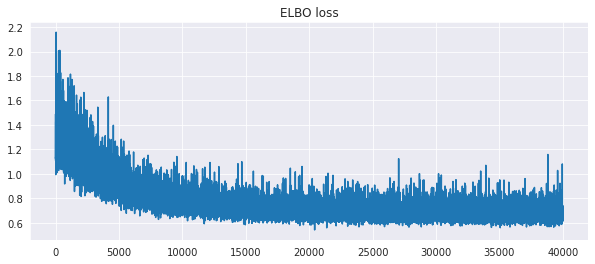

In [27]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(losses)
ax.set_title("ELBO loss");

In [32]:
w = pyro.get_param_store()["w_loc"]
b = pyro.get_param_store()["b_loc"]
print(f"Predicted w: \n {w}")
print(f"Predicted b: \n {b}")

def predict_class(x):
    out = torch.argmax(torch.matmul(x,w)+b,dim=1) 
    # out = torch.argmax(torch.softmax(torch.matmul(x,w)+b,dim=1),dim=1) # to have probabilities of each class
    return out

Predicted w: 
 tensor([[-1.0233e+00, -1.8158e-02,  1.2047e+00],
        [ 2.0367e+00, -1.4405e+00, -4.9826e-01],
        [-2.3522e+00,  9.3367e-01,  1.5588e+00],
        [-2.3578e+00,  1.5424e-03,  2.4097e+00]], requires_grad=True)
Predicted b: 
 tensor([[ 1.6804,  1.1383, -1.7021]], requires_grad=True)


In [34]:
correct_predictions = (predict_class(x_test) == y_test).sum().item()

print(f"test accuracy = {correct_predictions/len(x_test)*100:.2f}%")

test accuracy = 90.00%
